In [2]:
# ruff: noqa: E402
%run _common.ipynb
%matplotlib inline

import torch
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt

from node_homotopy.dynamics import LotkaVolterra, RobertsonChemReaction, VanderPol
from node_homotopy.odesolve import odesolve
from node_homotopy.smoothing import CubicSplineSmoothing
from node_homotopy.synchronization import CouplingTerm, SynchronizedDynamics

# Constucting smoothing cubic spline of given dynamics data


## Stiff systems
In the case of stiff systems, the constructed smoothing spline does result in over-smoothing at points where the state changes abruptly.

This is not surprising because smoothing can be thought of as low pass filtering in the frequency domain, and abrupt changes (sharp peaks, edges, etc) contain high frequency components.

We illustrate this using two examples - the Van der Pol oscillator and the Robertson system.

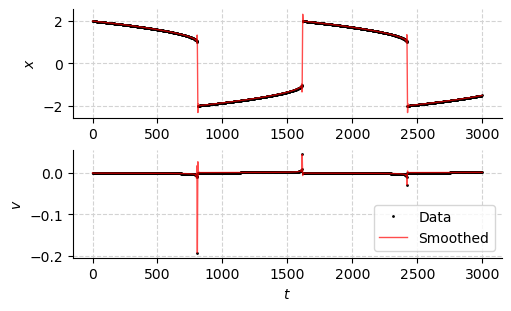

In [6]:
# Create and solve the Van der Pol system
vanderpol = VanderPol()
t = torch.arange(0.0, 3000.0, 3.0, dtype=torch.float64)
u0 = torch.tensor([2.0, 0.0], dtype=torch.float64).view(1, -1)
with torch.no_grad():
    u = odesolve(
        vanderpol,
        u0,
        t,
        method="scipy_solver",
        rtol=1e-9,
        atol=1e-9,
        options={"solver": "Radau"},
    )

# Construct smoothing spline and compute smoothed trajectory
smoothing_spline = CubicSplineSmoothing(t, u)
t_smooth = torch.arange(0.0, 3000.0, 0.3, dtype=torch.float64)
with torch.no_grad():
    u_smooth = smoothing_spline(t_smooth)

# Plot results
fig, axes = plt.subplots(vanderpol.dof, 1)
ylabels = ("x", "v")
for i, (ax, ylab) in enumerate(zip(axes, ylabels)):
    ax.plot(t, u[0, i], ".", color="black", label="Data")
    ax.plot(t_smooth, u_smooth[0, i], "-", color="red", label="Smoothed", alpha=0.7)
    ax.set_ylabel(f"${ylab}$")
axes[-1].set_xlabel("$t$")
axes[-1].legend(loc="lower right")

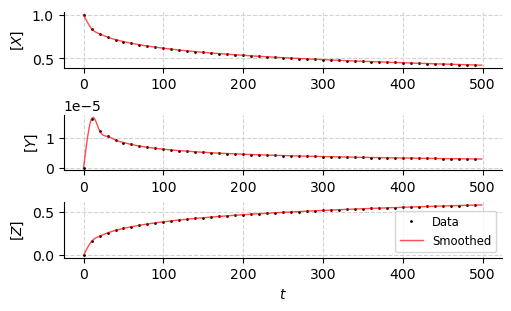

In [8]:
# Create and solve the Robertson system
robertson = RobertsonChemReaction()
t = torch.arange(0.0, 500.0, 10, dtype=torch.float64)
u0 = torch.tensor([1.0, 0.0, 0.0], dtype=torch.float64).view(1, -1)
with torch.no_grad():
    u = odesolve(robertson, u0, t, method="scipy_solver", options={"solver": "Radau"})

# Construct smoothing spline and compute smoothed trajectory
smoothing_spline = CubicSplineSmoothing(t, u)
t_smooth = torch.arange(0.0, 500.0, 1, dtype=torch.float64)
with torch.no_grad():
    u_smooth = smoothing_spline(t_smooth)

fig, axes = plt.subplots(
    robertson.dof,
    1,
)
ylabels = ("X", "Y", "Z")
for i, (ax, ylab) in enumerate(zip(axes, ylabels)):
    ax.plot(t, u[0, i], ".", color="black", label="Data")
    ax.plot(t_smooth, u_smooth[0, i], "-", color="red", label="Smoothed", alpha=0.7)
    ax.set_ylabel(f"$[{ylab}]$")
axes[-1].set_xlabel("$t$")
axes[-1].legend(loc="lower right", fontsize="small")